# Loan Default Prediction Analysis

## Introduction

This notebook focuses on analyzing and predicting loan defaults using the `loan.csv` dataset provided by MoneyLion. The main objectives are:

1. **Data Loading**:
   - Load and inspect the datasets: `loan.csv`, `payment.csv`, and `clarity_underwriting_variables.csv`.
   - Understand the structure and content of each dataset.

2. **Data Preparation**:
   - Merge the `loan` dataset with the `underwriting` dataset to enrich the loan data.
   - Filter to include only funded loans.
   - Select relevant columns and sort by application date.

3. **Data Cleaning**:
   - Analyze missing values to determine columns needing special handling.
   - Convert date columns to datetime format.

4. **Feature Engineering**:
   - Create new features and transform existing ones to enhance predictive power.

5. **Exploratory Data Analysis**:
   - Visualize the distribution of loan statuses and other key insights.

6. **Model Training**:
   - Train and evaluate predictive models to identify factors contributing to loan defaults.
   - Use the cleaned and engineered dataset to build robust models.

7. **Feature Importance Plot**
    - Visualize the importance of each feature in loan default prediction
      

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


### 1. Data Loading:

- **Loan Data (`loan.csv`)**: This dataset contains information about loans, including identifiers, repayment frequency, APR, application and origination dates, loan amounts, and various status indicators.
- **Payment Data (`payment.csv`)**: This dataset includes details about payments made towards the loans, including payment dates, amounts, and statuses.
- **Underwriting Data (`clarity_underwriting_variables.csv`)**: This dataset provides additional variables used in underwriting the loans, including a fraud score (`clearfraudscore`) provided by Clarity, which is particularly useful for assessing the risk of default.


In [2]:
loan_df = pd.read_csv("../data/raw/loan.csv", parse_dates=['applicationDate', 'originatedDate'])
payment_df = pd.read_csv("../data/raw/payment.csv")
underwriting_df = pd.read_csv("../data/raw/clarity_underwriting_variables.csv", low_memory=False)

In [3]:
print(f'Loan df shape :{loan_df.shape}')
print(f'Payment df shape :{payment_df.shape}')
print(f'Underwriting df shape :{underwriting_df.shape}')

Loan df shape :(577682, 19)
Payment df shape :(689364, 9)
Underwriting df shape :(49752, 54)


## Data Dictionary for `loan.csv`
| Column Name                       | Description                                                                                                           |
|-----------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| `loanId`                          | A unique loan identifier.|
| `anon_ssn`                        | A hash based on a client’s SSN. Use this as if it is an SSN to compare if a loan belongs to a previous customer.       |
| `payFrequency`                    | Repayment frequency of the loan: `B` (biweekly), `I` (irregular), `M` (monthly), `S` (semi-monthly), `W` (weekly).     |
| `apr`                             | The loan APR percentage.                                                                                               |
| `applicationDate`                 | Date of application (start date).                                                                                      |
| `originated`                      | Whether or not a loan has been originated (first step of underwriting before loan is funded).                          |
| `originatedDate`                  | Date of origination - day the loan was originated.                                                                     |
| `nPaidOff`                        | Number of MoneyLion loans this client has paid off in the past.                                                        |
| `approved`                        | Whether or not a loan has been approved (final step of underwriting before a loan deposit is attempted).               |
| `isFunded`                        | Whether or not a loan is ultimately funded. A loan can be voided by a customer shortly after it is approved, so not all approved loans are ultimately funded. |
| `loanStatus`                      | Current loan status. Most are self-explanatory. Clarifications: `Returned Item` (missed 1 payment due to insufficient funds), `Rejected` (by automated underwriting rules), `Withdrawn Application` (abandoned for more than 2 weeks or withdrawn by a human underwriter or customer), statuses with “void” mean a loan that is approved but cancelled (e.g., failed to be debited into the customer’s account). |
| `loanAmount`                      | Principal of loan – for non-funded loans this will be the principal in the loan application.                           |
| `originallyScheduledPaymentAmount`| The originally scheduled repayment amount (if a customer pays off all his scheduled payments, this is the amount we should receive). |
| `state`                           | Client’s state.                                                                                                        |
| `leadType`                        | The lead type determines the underwriting rules for a lead: `bvMandatory` (bank verification required before loan approval), `lead` (similar to `bvMandatory` but bank verification is optional), `california` (optimized for California lending rules), `organic` (came through the MoneyLion website), `rc_returning` (customers with at least 1 paid off loan in another loan portfolio), `prescreen` (preselected customers offered a loan through direct mail campaigns), `express` (promotional “express” loans), `repeat` (promotional loans offered through SMS), `instant-offer` (promotional “instant-offer” loans). |
| `leadCost`                        | Cost of the lead.                                                                                                      |
| `fpStatus`                        | Result of the first payment of the loan: `Checked` (payment is successful), `Rejected` (payment is unsuccessful), `Cancelled` (payment is cancelled), `No Payments/No Schedule` (loan is not funded), `Pending` (ACH attempt submitted to clearing house but no response yet), `Skipped` (payment has been skipped), `None` (No ACH attempt made yet – usually because the payment is scheduled for the future). |
| `clarityFraudId`                  | Unique underwriting ID. Can be used to join with columns in the `clarity_underwriting_variables.csv` file.             |


### 1.1 Merging DataFrames

- The `loan_df` is merged with the `underwriting_df` on the `clarityFraudId` from the loan data and `underwritingid` from the underwriting data. This enriches the loan data with additional underwriting variables.

- Importance of `clearfraudscore`: This column is critical as it provides a fraud score used in assessing the risk of loan default, making it a valuable feature in predictive modeling.

In [4]:
df = pd.merge(loan_df, underwriting_df, left_on="clarityFraudId", right_on="underwritingid", how="left")
df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,...,NaN,partial,NaN,D04,NaN,NaN,invalid,5.0,879.0,569eb3a3e4b096699f685d64
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### When merging datasets, check whether each loanId remains unique after the merge.

1. Data Integrity
    - Consistency : Ensuring that each loan has a unique identifier maintains the consistency of the dataset. This helps in avoiding duplicate records which can skew analysis and model training.

2. Simplified Analysis
    - Unique loanId values simplify data analysis by ensuring that each row represents a distinct loan. This makes it easier to compute statistics, generate insights, and visualize the data.

In [5]:
# Check if the loanId column is unique after merging
unique_loan_ids = df['loanId'].is_unique

# Display the result
unique_loan_ids

False

### 2. Data Preparation

#### 2.1 Selecting Only Loans that have been funded

- This step filters the dataset to include only the loans that have been funded. Funded loans are those that have successfully passed through all stages of the loan approval process and have been disbursed to the borrower.

- By filtering for funded loans, the dataset only includes loans that were fully approved and disbursed, which are the loans relevant for default prediction.

In [6]:
df = df[df['isFunded'] == 1]

In [7]:
df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,...,NaN,partial,NaN,D04,NaN,NaN,invalid,5.0,879.0,569eb3a3e4b096699f685d64
15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28T19:54:22.982000,True,2016-11-29T20:30:40.640000,2.0,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,2017-03-01T16:15:13.016000,0.0,True,1,...,(U) Unlisted,match,NaN,NaN,NaN,NaN,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,True,2017-01-31T18:00:14.520000,2.0,True,1,...,(M) Mobile Phone,partial,NaN,NaN,NaN,A8,match,6.0,835.0,58450a15e4b0bb9d6d7344c7
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,True,2016-08-29T15:05:04.014000,0.0,True,1,...,(P) Pager,match,NaN,NaN,NaN,NaN,match,1.0,624.0,578f9346e4b0810ad5e7b72e


### 2.2 Selecting Only Relevant Columns for loan default analysis

- This step reduces the dataset to only include columns that are relevant for analyzing loan default. Irrelevant columns are dropped to simplify the dataset and focus on the most important features.

- | Column Name                           | Description                                                                                                           |
|---------------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| `loanId`                              | A unique loan identifier. Use this for joins with the `payment.csv` file.                                              |
| `anon_ssn`                            | A hash based on a client’s SSN. Use this as if it is an SSN to compare if a loan belongs to a previous customer.       |
| `payFrequency`                        | Repayment frequency of the loan: `B` (biweekly), `I` (irregular), `M` (monthly), `S` (semi-monthly), `W` (weekly).     |
| `apr`                                 | The loan APR percentage.                                                                                               |
| `applicationDate`                     | Date of application (start date).                                                                                      |
| `originatedDate`                      | Date of origination - day the loan was originated.                                                                     |
| `nPaidOff`                            | Number of MoneyLion loans this client has paid off in the past.                                                        |
| `loanStatus`                          | Current loan status. Clarifications: `Returned Item` (missed 1 payment due to insufficient funds), `Rejected` (by automated underwriting rules), `Withdrawn Application` (abandoned for more than 2 weeks or withdrawn by a human underwriter or customer), statuses with “void” mean a loan that is approved but cancelled (e.g., failed to be debited into the customer’s account). |
| `loanAmount`                          | Principal of loan – for non-funded loans this will be the principal in the loan application.                           |
| `originallyScheduledPaymentAmount`    | The originally scheduled repayment amount (if a customer pays off all his scheduled payments, this is the amount we should receive). |
| `state`                               | Client’s state.                                                                                                        |
| `leadType`                            | The lead type determines the underwriting rules for a lead: `bvMandatory` (bank verification required before loan approval), `lead` (similar to `bvMandatory` but bank verification is optional), `california` (optimized for California lending rules), `organic` (came through the MoneyLion website), `rc_returning` (customers with at least 1 paid off loan in another loan portfolio), `prescreen` (preselected customers offered a loan through direct mail campaigns), `express` (promotional “express” loans), `repeat` (promotional loans offered through SMS), `instant-offer` (promotional “instant-offer” loans). |
| `leadCost`                            | Cost of the lead.                                                                                                      |
| `fpStatus`                            | Result of the first payment of the loan: `Checked` (payment is successful), `Rejected` (payment is unsuccessful), `Cancelled` (payment is cancelled), `No Payments/No Schedule` (loan is not funded), `Pending` (ACH attempt submitted to clearing house but no response yet), `Skipped` (payment has been skipped), `None` (No ACH attempt made yet – usually because the payment is scheduled for the future). |
| `clearfraudscore`                     | Fraud score provided by Clarity, used to assess the risk of loan default.                                               |


In [8]:
# Select only relevant columns
df = df[["payFrequency", "apr", "applicationDate", "originatedDate", "nPaidOff", "loanStatus",
         "loanAmount", "originallyScheduledPaymentAmount", "state", "leadType", "leadCost", "fpStatus", "clearfraudscore"]]

In [9]:
print(f'df shape : {df.shape}')
df.head()

df shape : (38982, 13)


,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clearfraudscore
1,B,199.0,2016-01-19T22:07:36.778000,2016-01-20T15:49:18.846000,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,879.0
15,B,475.0,2016-11-28T19:54:22.982000,2016-11-29T20:30:40.640000,2.0,New Loan,350.0,893.88,MO,organic,0,Checked,NaN
33,W,645.0,2017-03-01T15:55:41.823000,2017-03-01T16:15:13.016000,0.0,New Loan,400.0,1364.87,NJ,lead,40,Checked,658.0
47,S,490.0,2017-01-31T17:48:17.381000,2017-01-31T18:00:14.520000,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,835.0
54,B,590.0,2016-08-27T09:08:05.442000,2016-08-29T15:05:04.014000,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,624.0


In [10]:
df['nPaidOff'].unique()

array([ 0.,  2.,  3.,  1.,  4.,  5.,  7.,  6., 18., 13., nan, 19., 10.,
        8., 11.,  9., 15., 12., 21., 17., 14., 16., 20.])

### 1.3 Chronological Sorting

- Sorting the dataset chronologically by the application date ensures that the data is in temporal order. This is crucial for time-series analysis and for preventing data leakage during model training.

In [11]:
df = df.sort_values(by="applicationDate")

In [12]:
df

,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clearfraudscore
169457,B,478.67,2014-12-03T00:31:22.306000,2014-12-03T03:12:58.466000,NaN,Settlement Paid Off,800.0,2035.32,OH,lead,25,Checked,NaN
229094,B,478.67,2014-12-03T00:39:02.866000,2014-12-02T17:47:22,NaN,External Collection,800.0,1919.28,OH,lead,6,Checked,NaN
116604,B,478.67,2014-12-03T00:39:07.767000,2014-12-04T17:26:49.668000,NaN,External Collection,800.0,1919.28,OH,lead,25,Checked,NaN
151364,S,705.59,2014-12-03T00:41:27.773000,2014-12-03T03:12:56.416000,NaN,External Collection,200.0,739.08,OH,lead,25,Checked,NaN
555793,B,478.67,2014-12-03T00:43:10.714000,2014-12-03T03:12:55.376000,NaN,External Collection,500.0,1199.55,OH,lead,25,Rejected,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444971,S,199.00,2017-03-18T23:20:54.652000,2017-03-21T12:43:20.204000,1.0,New Loan,2600.0,9775.69,CA,organic,0,Checked,NaN
155458,S,199.00,2017-03-18T23:27:17.159000,2017-03-19T01:00:09.167000,0.0,New Loan,3000.0,10115.60,CA,lead,40,Checked,NaN
209082,B,645.00,2017-03-18T23:34:27.369000,2017-03-19T00:15:16.291000,1.0,Paid Off Loan,500.0,1755.78,FL,organic,0,Checked,836.0
542600,B,360.00,2017-03-18T23:38:50.917000,2017-03-18T23:45:05.393000,0.0,Returned Item,1500.0,3222.20,IL,lead,25,Rejected,NaN


### 2.4 Visualization

- These visualizations show the proportion of loan statuses for funded and non-funded loans. The bar plots help in understanding the distribution of loan statuses within each category, providing insights into the success rates and common issues.

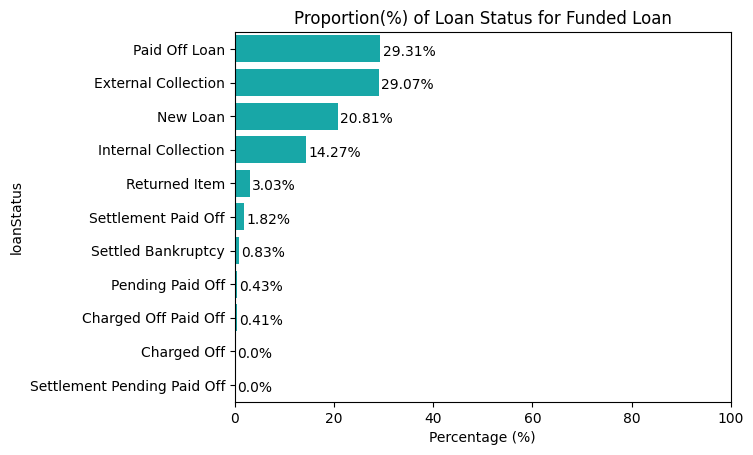

In [13]:
funded_loan = loan_df[loan_df['isFunded'] == 1]
funded_loan_status_cat = round(funded_loan['loanStatus'].value_counts(normalize=True).mul(100), 2).to_frame(name='pct')

ax = sns.barplot(data=funded_loan_status_cat, y=funded_loan_status_cat.index, x='pct', color='c')
ax.set_title('Proportion(%) of Loan Status for Funded Loan')
ax.set_xlabel('Percentage (%)')
ax.set(xlim=(0,100))

for p in ax.patches:
    txt = str(p.get_width().round(2)) + '%'
    txt_x = p.get_width() + 0.5
    txt_y = p.get_y() + 0.6
    ax.text(txt_x,txt_y,txt)

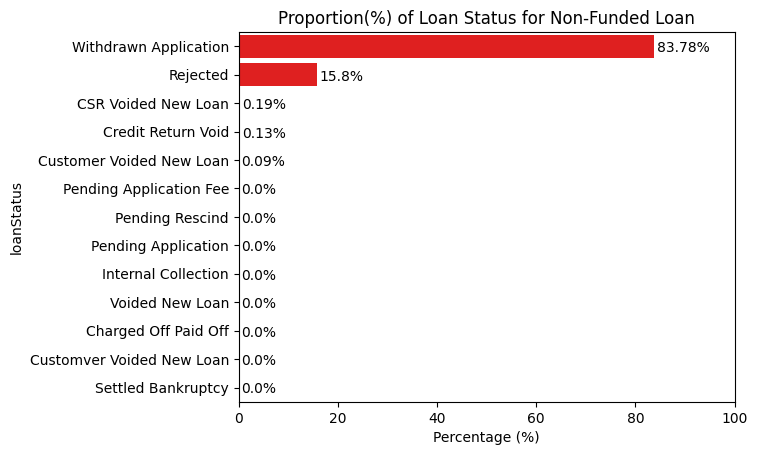

In [14]:
not_funded_loan = loan_df[loan_df['isFunded'] == 0]
not_funded_loan_status_cat = round(not_funded_loan['loanStatus'].value_counts(normalize=True).mul(100), 2).to_frame(name='pct')

ax = sns.barplot(data=not_funded_loan_status_cat, y=not_funded_loan_status_cat.index, x='pct', color='red')
ax.set_title('Proportion(%) of Loan Status for Non-Funded Loan')
ax.set_xlabel('Percentage (%)')
ax.set(xlim=(0,100))

for p in ax.patches:
    txt = str(p.get_width().round(2)) + '%'
    txt_x = p.get_width() + 0.5
    txt_y = p.get_y() + 0.6
    ax.text(txt_x,txt_y,txt)

## 3. Data Cleaning

- **Calculating Percentage of Missing Values**:
  This step calculates the percentage of missing values for each column in the dataset. Identifying columns with significant amounts of missing data helps in deciding whether to keep, drop, or impute them.

### 3.1 Handling Missing Values in LightGBM

- **Technical Explanation**:
  - **Built-in Handling**: LightGBM has a built-in mechanism to handle missing values. It treats missing values (NA or NaN) by assigning them to a specific direction (left or right) in the decision tree during the split condition evaluation. This mechanism is enabled by default.
  - **Optimal Default Direction**: During training, LightGBM determines the optimal direction for missing values, choosing the path that minimizes the loss function the most. This allows LightGBM to effectively handle missing data without requiring explicit imputation.
  - **Advantages**: This method leverages the presence of missing values to enhance the model’s predictive power and avoids the need for additional preprocessing steps to handle missing data.

- **Practical Consideration**:
  - **Threshold for Missing Values**: It is practical to keep columns with less than 20-30% missing values, as LightGBM can handle these effectively. This threshold ensures that most of the data is utilized while still benefiting from LightGBM's handling of missing values.

### Reference Links
- [LightGBM Documentation on Missing Values](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle)


In [15]:
percentage_missing_values_df = (df.isnull().mean() * 100).sort_values(ascending=False)
print(percentage_missing_values_df)

clearfraudscore                     17.685085
nPaidOff                             0.053871
fpStatus                             0.023088
payFrequency                         0.000000
apr                                  0.000000
originatedDate                       0.000000
applicationDate                      0.000000
loanStatus                           0.000000
loanAmount                           0.000000
state                                0.000000
originallyScheduledPaymentAmount     0.000000
leadCost                             0.000000
leadType                             0.000000
dtype: float64


### 3.2 Convert Columns to Datetime Format

- Converting date columns to datetime format ensures that the dates are correctly recognized and can be used in time-series analysis and other date-related computations.

In [16]:
# Convert columns to datetime format using ISO 8601 format
df['originatedDate'] = pd.to_datetime(df['originatedDate'], format='mixed')
df['applicationDate'] = pd.to_datetime(df['applicationDate'], format='mixed')

## 4. Feature Engineering & Transformation

Feature engineering involves creating new features or transforming existing features to improve the performance of machine learning models. In this step, we focus on engineering features relevant to predicting loan defaults.

### 4.1 Creating Target Variable
- This step creates a binary target variable (target) where loans that fall into default_classes are labeled as 1 (default), and loans in paid_off_classes are labeled as 0 (paid off).

- Loans that do not fall into either category are removed from the dataset to ensure the target variable is well-defined for all remaining rows.

| Loan Status                   | Category               | Justification                                                                                         |
|-------------------------------|------------------------|-------------------------------------------------------------------------------------------------------|
| Paid Off Loan                 | Paid Off | Loan has been fully paid off without issues; no default involved.                                      |
| New Loan                      | Paid Off | Represents a newly issued loan; no default has occurred yet.                                           |
| Pending Paid Off              | Paid Off | Loan is in the process of being paid off; not in default.                                              |
| Internal Collection           | Related to Default     | Indicates that the loan is in default and is being handled by the lender's internal collection team.   |
| External Collection           | Related to Default     | Indicates that the loan is in default and has been sent to an external collection agency.              |
| Returned Item                 | Related to Default     | Missed a payment due to insufficient funds; indicates potential default situation.                     |
| Charged Off Paid Off          | Related to Default     | Loan was charged off (defaulted) but has since been paid off.                                          |
| Settled Bankruptcy            | Related to Default     | Indicates the loan was involved in bankruptcy proceedings, usually implying default.                   |
| Settlement Paid Off           | Related to Default     | Indicates a settlement was reached and paid off, typically after a default situation.                  |
| Charged Off                   | Related to Default     | Indicates the loan has been written off as a loss due to default.                                      |
| Settlement Pending Paid Off   | Related to Default     | Loan is in the process of being settled and paid off, typically following default.                     |


In [17]:
default_classes = ['Internal Collection', 'External Collection', 'Returned Item', 
                   'Charged Off Paid Off', 'Settled Bankruptcy', 'Settlement Paid Off', 'Charged Off', 
                   'Settlement Paid Off']
paid_off_classes = ['Paid Off Loan', "New Loan", "Pending Paid Off"]

df.loc[df['loanStatus'].isin(default_classes).values, 'target'] = 1
df.loc[df['loanStatus'].isin(paid_off_classes).values, 'target'] = 0
df = df.loc[~df['target'].isnull()].reset_index(drop=True)

### 4.2 Creating Target Variable

- This feature calculates the total hours taken from the application date to the origination date of the loan. It is a continuous variable that represents the time taken for the loan application to be processed and originated.

- The time taken for loan processing might be an important factor in understanding the efficiency and potential risks associated with different loans.

### Table: Feature Descriptions

| Feature                   | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| `app_processing_hours`    | Continuous variable representing the total hours from application date to origination date. |


In [18]:
# Calculate the difference in hours
df['app_processing_hours'] = (df['originatedDate'] - df['applicationDate']).dt.total_seconds() / 3600

In [19]:
df.head()

,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clearfraudscore,target,app_processing_hours
0,B,478.67,2014-12-03 00:31:22.306,2014-12-03 03:12:58.466,NaN,Settlement Paid Off,800.0,2035.32,OH,lead,25,Checked,NaN,1.0,2.693378
1,B,478.67,2014-12-03 00:39:02.866,2014-12-02 17:47:22.000,NaN,External Collection,800.0,1919.28,OH,lead,6,Checked,NaN,1.0,-6.861352
2,B,478.67,2014-12-03 00:39:07.767,2014-12-04 17:26:49.668,NaN,External Collection,800.0,1919.28,OH,lead,25,Checked,NaN,1.0,40.794973
3,S,705.59,2014-12-03 00:41:27.773,2014-12-03 03:12:56.416,NaN,External Collection,200.0,739.08,OH,lead,25,Checked,NaN,1.0,2.524623
4,B,478.67,2014-12-03 00:43:10.714,2014-12-03 03:12:55.376,NaN,External Collection,500.0,1199.55,OH,lead,25,Rejected,NaN,1.0,2.495739


In [20]:
# Convert 'target' column to int if it's not already
df['target'] = df['target'].astype(int)

### 4.3 Why LightGBM Does Not Require Feature Normalization

LightGBM inherently handles feature scaling and normalization within its tree-based architecture. The decision trees in LightGBM do not require features to be on the same scale since they split on the value of features rather than their magnitudes. This characteristic simplifies the preprocessing pipeline by eliminating the need for explicit normalization or standardization.

## Refernce Links
- [https://medium.com/atoti/when-to-perform-a-feature-scaling-11a7fb4f9f13](https://medium.com/atoti/when-to-perform-a-feature-scaling-11a7fb4f9f13)

## 5. Explanatory Data Analysis

### 5.1 Bar Chart
- The count plot visualizes the distribution of the target variable, which indicates whether a loan was paid off (0) or defaulted (1). 

- The plot shows that the counts of `paid-off loans` and `defaulted loans` are roughly similar. This indicates that the dataset is relatively balanced with respect to the target variable. 

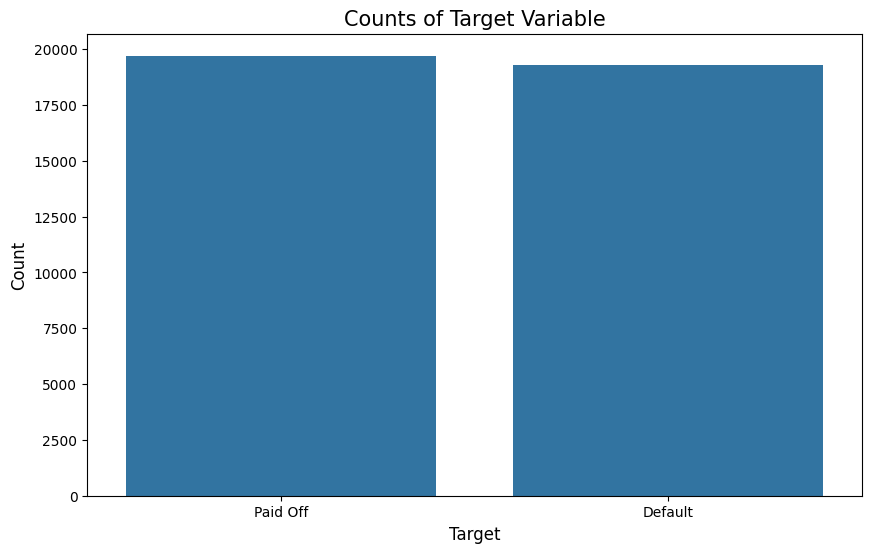

In [21]:
# Create a count plot for the 'target' variable
plt.figure(figsize=(10, 6))

sns.countplot(x='target', data=df)
plt.xticks(ticks=[0, 1], labels=['Paid Off', 'Default'])
plt.title('Counts of Target Variable', fontsize=15)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


### 5.2 Grouped Bar Chart
The bar plot below shows the percentage distribution of loan repayment statuses (Paid Off and Default) across different pay frequencies. Here’s an analysis of the plot:

1. Pay Frequency Categories
   - The pay frequencies are categorized into `Biweekly`, `Irregular`, `Monthly`, `Semi-monthly`, and `Weekly`.


2. Distribution of Paid Off vs. Default
    - `Biweekly`: Roughly the same proportion of defaults compared to paid-off
    - `Irregular`: Exhibits a higher proportion of paid-off.
    - `Monthly`: Has a significant percentage of loans being paid off, with defaults being lower but noticeable.
    - `Semi-monthly`: Has a significant percentage of loans being paid off, with defaults being lower but noticeable.
    - `Weekly`: Exhibits a higher proportion of defaults.

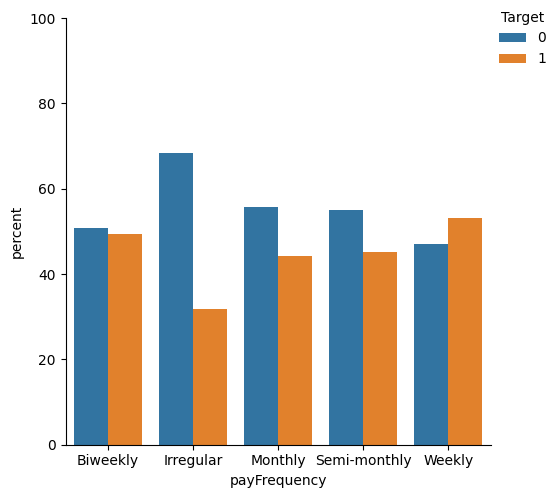

In [22]:
# Define variables
x, y = 'payFrequency', 'target'

# Copy dataframe
df1 = df.copy()

# Define the mapping
mapping = {
    "B": "Biweekly",
    "I": "Irregular",
    "M": "Monthly",
    "S": "Semi-monthly",
    "W": "Weekly"
}

# Apply the mapping to the 'payFrequency' column
df1[x] = df1[x].replace(mapping)

# Group by payFrequency and target, calculate percentage
df1 = df1.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

# Plot
g = sns.catplot(x=x, y='percent', hue=y, kind='bar', data=df1)
g.ax.set_ylim(0,100)

# Customize legend
g._legend.set_title("Target")

# Move the legend to the top right
g._legend.set_bbox_to_anchor((1, 1))
g._legend.set_loc('upper right')

plt.show()

### 5.3 Box Plot
This code below generates a boxplot to visualize the distribution of the `clearfraudscore` variable for two groups: loans that were paid off and loans that defaulted. 

### Interpretation of the Plot
The boxplot will show the distribution of clearfraudscore for loans that were paid off versus those that defaulted. Key points to analyze include:

- `Median Values`: The line inside each box represents the median clearfraudscore for each category.
- `Interquartile Range (IQR)`: The box itself represents the IQR, which contains the middle 50% of the data.
- `Whiskers and Outliers`: The whiskers extend to 1.5 times the IQR, and any points outside this range are considered outliers and plotted as individual points.
- `Comparison`: By comparing the distributions, we can observe whether there are significant differences in `clearfraudscore` between paid off and defaulted loans. For instance, if defaulted loans have a lower median `clearfraudscore`, it would make sense because a higher fraud score suggests a lower probability of default.

/var/folders/nf/b3l22bv90bz1wwsyxnxnbkgc0000gp/T/ipykernel_10410/2119334702.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Paid Off', 'Default'])


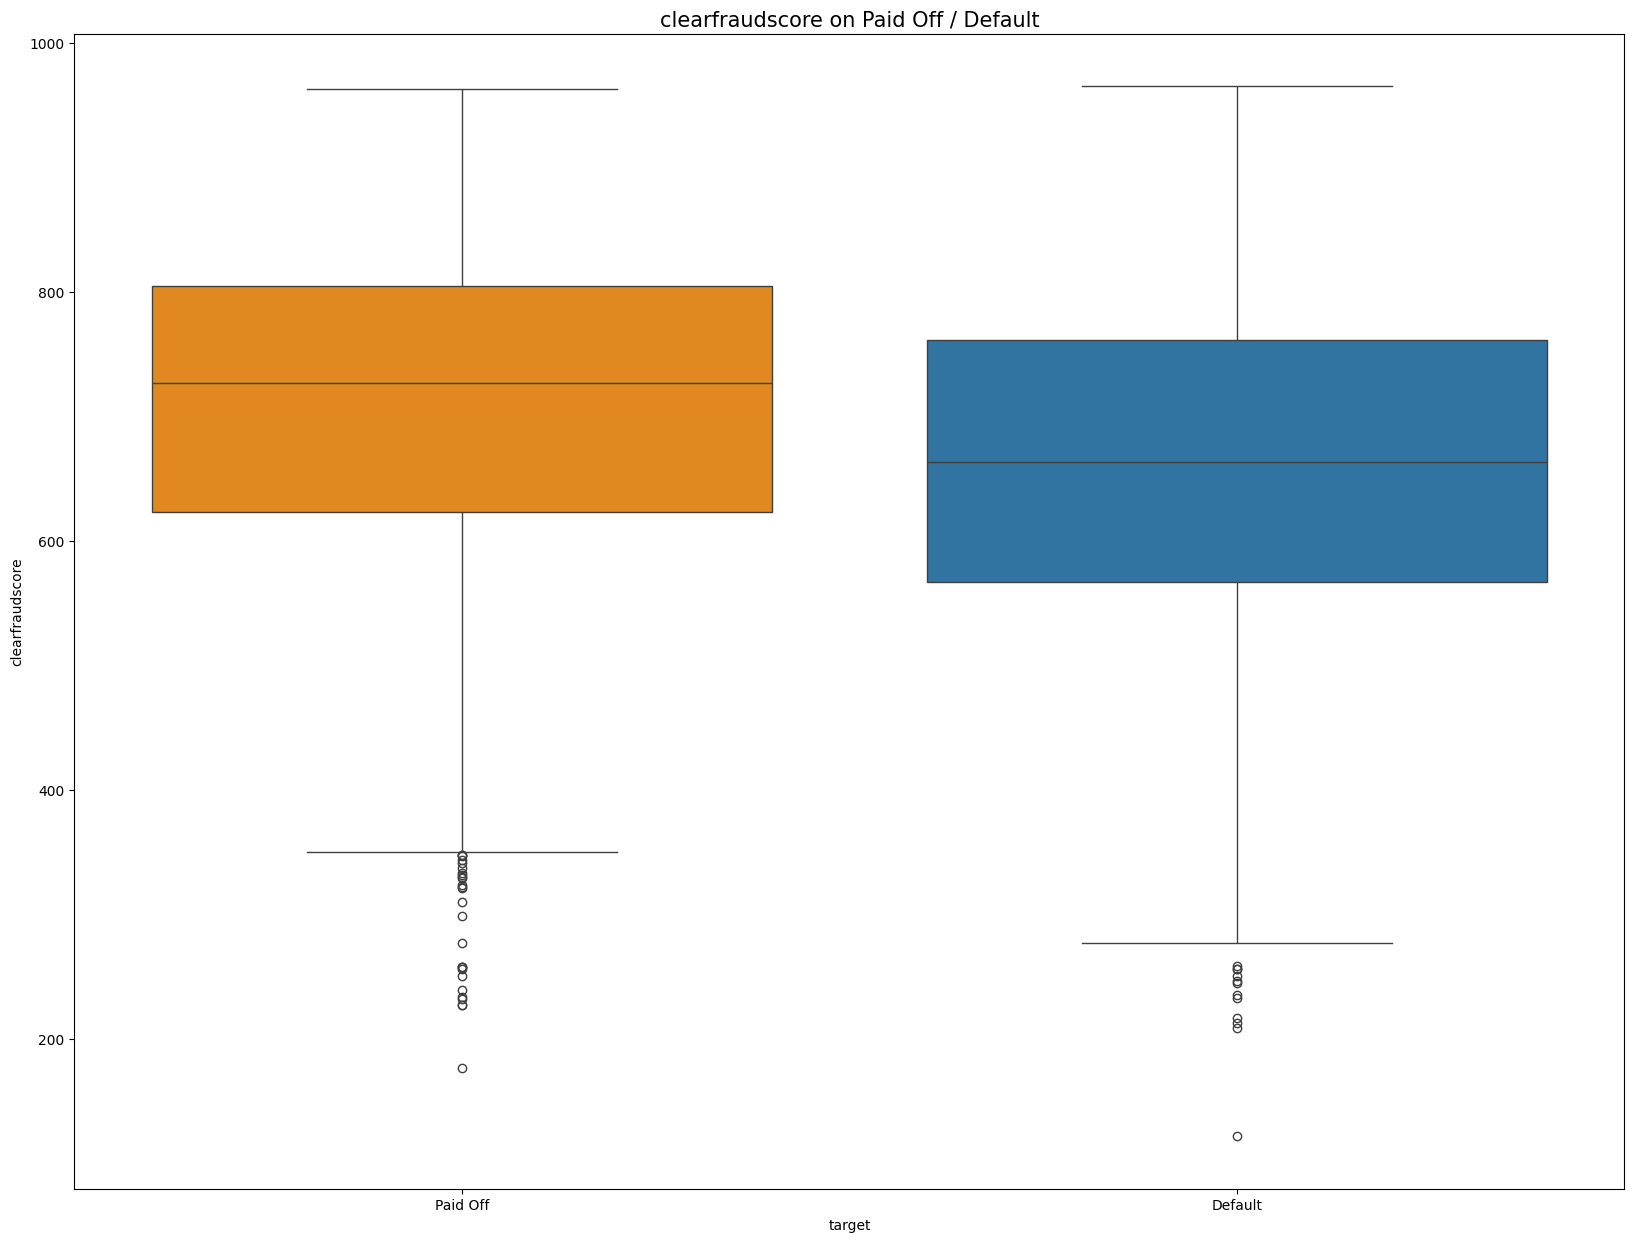

In [23]:
# Define the color palette for the target variable
my_palette = {0: "darkorange", 1: "tab:blue"}

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Create the boxplot with hue set to 'target'
sns.boxplot(x='target', y='clearfraudscore', data=df, palette=my_palette, hue='target', dodge=False, ax=ax)

# Set custom x-tick labels
ax.set_xticklabels(['Paid Off', 'Default'])

# Set the title of the plot
ax.set_title('clearfraudscore on Paid Off / Default', fontsize=15)

# Remove the legend
ax.legend_.remove()

plt.show()


## 6. Model Training

In [24]:
# Add the parent directory to the system path
sys.path.append('..')

from src.utils.data_preprocessing import load_data, preprocess_data, classify_loans, define_features, DataEncoder
from src.utils.model_training import hyperparameter_tuning, train_model

### 6.1 Data Loading

- The `load_data` function loads the datasets required for the analysis. It takes the paths to the loan, payment, and underwriting CSV files as input arguments and returns the respective DataFrames.

- `loan_df`: Contains information about loans, including loan amounts, statuses, and application details.
- `payment_df`: Includes payment details related to the loans, such as payment amounts and dates. (Not used here)
- `underwriting_df`: Provides underwriting variables, including a fraud score (clearfraudscore) provided by Clarity, which is useful for assessing the risk of loan default.

In [25]:
loan_csv_path = '../data/raw/loan.csv'
payment_csv_path = '../data/raw/payment.csv'
underwriting_path = '../data/raw/clarity_underwriting_variables.csv'

# Load data
loan_df, payment_df, underwriting_df = load_data(loan_csv_path, payment_csv_path, underwriting_path)

Loan df shape :(577682, 19)
Payment df shape :(689364, 9)
Underwriting df shape :(49752, 54)


/Users/munchong/Desktop/MoneyLion/MoneyLion_ML_take_home_test/notebook/../src/utils/data_preprocessing/extraction.py:24: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  underwriting_df = pd.read_csv(underwriting_path)


### 6.2 Preprocessing

- The `preprocess_data` function merges the loan_df with underwriting_df on the clarityFraudId column from the loan data and the underwritingid column from the underwriting data. This step enriches the loan data with additional underwriting variables. The function also filters out non-funded loans and selects only relevant columns necessary for the loan default prediction task.

In [26]:
# Preprocess data
df = preprocess_data(loan_df, underwriting_df)

In [27]:
df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clearfraudscore
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,2016-01-20T15:49:18.846000,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,879.0
15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28T19:54:22.982000,2016-11-29T20:30:40.640000,2.0,New Loan,350.0,893.88,MO,organic,0,Checked,NaN
33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,2017-03-01T16:15:13.016000,0.0,New Loan,400.0,1364.87,NJ,lead,40,Checked,658.0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,2017-01-31T18:00:14.520000,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,835.0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,2016-08-29T15:05:04.014000,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,624.0


### 6.3 Classify Loans

- The `classify_loans` function classifies loans into default and paid-off categories. It adds a new column named target to the DataFrame, where loans are classified as:

- `1 (default)`: Loans that fall under categories such as Internal Collection, External Collection, Charged Off, etc.
- `0 (paid off)`: Loans that are fully paid off or in the process of being paid off.

- This binary classification is essential for building a predictive model to determine the likelihood of loan defaults.

In [28]:
# Classify loans
df = classify_loans(df)

### 6.4 Sort Data Chronologically

- Sorting the data by the `applicationDate` ensures that the training and testing sets are chronologically ordered. This step is crucial to prevent data leakage, which occurs when future information is used to predict past events. By maintaining temporal coherence, we ensure that the model is trained and evaluated in a realistic scenario, reflecting how new loan applications would be processed and assessed over time.

In [29]:
# Sort the data in chronological order to prevent data leakage
df = df.sort_values(by="applicationDate")


### 6.5 Define Features

The `define_features` function defines and categorizes the features used for modeling into numerical features (`num_feats`), frequency encoded features (`freq_feats`), target encoded features (`target_feats`), and the predictor feature (`predictor`). This step ensures that all relevant features are properly identified and prepared for the encoding and modeling process.

- `num_feats`: Numerical features that are used directly in the model.
- `freq_feats`: Categorical features that will be encoded based on their frequency.
- `target_feats`: Categorical features that will be target encoded.
- `predictor`: The target variable that the model aims to predict.

In [30]:
num_feats, freq_feats, target_feats, predictor = define_features()

selected_features = list(set(num_feats + freq_feats + target_feats + predictor))

print(f"Numerical Features :{num_feats}")
print(f"Frequency Features : {freq_feats}")
print(f"Target Features : {target_feats}")
print(f"Predictor : {predictor}")

Numerical Features :['apr', 'loanAmount', 'originallyScheduledPaymentAmount', 'leadCost', 'app_processing_hours', 'clearfraudscore']
Frequency Features : ['payFrequency', 'nPaidOff', 'state', 'fpStatus', 'leadType']
Target Features : ['payFrequency', 'nPaidOff', 'state', 'fpStatus', 'leadType']
Predictor : ['target']


### 6.6 Split Data into Train, Validation, and Test Sets

The dataset is split into training, validation, and test sets to facilitate model training and evaluation. The splitting is done based on a timeline to ensure temporal coherence:

- `train_size`: 80% of the data is used for training the model.
- `val_size`: 10% of the data is used for validating the model during hyperparameter tuning.
- The remaining 10% of the data is used as a test set to evaluate the final model's performance.

In [31]:
# Split data into train, validation, and test sets based on timeline
train_size = int(len(df) * 0.8)  # 80% for training
val_size = int(len(df) * 0.1)    # 10% for validation
train_val_df = df[:train_size + val_size]
test_df = df[train_size + val_size:]

### 6.7 Initialize the Encoder

- The `DataEncoder` class is initialized with the numerical, target encoded, and frequency encoded features. This encoder will be used to transform the categorical features into numerical values suitable for modeling.

In [32]:
# Initialize the encoder
encoder = DataEncoder(num_feats, target_feats, freq_feats)


### 6.8 Encode the Training and Validation Data

The `fit_transform` method of the `DataEncoder` class is used to fit the encoder on the training and validation data, transforming the categorical features into numerical values. This method ensures that the encoder learns from the training data and applies the same transformations consistently.

- `X_train_val`: Encoded features for the combined training and validation set.
- `y_train_val`: Target variable for the combined training and validation set.


In [33]:
# Encode the training & validation data
X_train_val = encoder.fit_transform(train_val_df, predictor)
y_train_val = train_val_df[predictor]


### 6.9 Split the Transformed Data into Train and Validation Sets

The encoded training and validation data are split into separate training and validation sets based on the previously defined `train_size` and `val_size`. This step ensures that the model can be trained on the training set and validated on the validation set to evaluate its performance during hyperparameter tuning.

- `X_train`: Encoded features for the training set.
- `X_val`: Encoded features for the validation set.
- `y_train`: Target variable for the training set.
- `y_val`: Target variable for the validation set.

In [34]:
# Encode the training & validation data
X_train_val = encoder.fit_transform(train_val_df, predictor)
y_train_val = train_val_df[predictor]

# Split the transformed data into train and validation splits
X_train = X_train_val[:train_size]
X_val = X_train_val[train_size:]

y_train = y_train_val[:train_size]
y_val = y_train_val[train_size:]

### 6.10 Hyperparameter Tuning

The `hyperparameter_tuning` function performs hyperparameter tuning using the training and validation sets. 
It uses the Hyperopt library to optimize the hyperparameters of a LightGBM model, aiming to find the best combination of hyperparameters 
that maximizes the F1 score on the validation set. 
This step helps in improving the model's performance by finding the optimal settings for the learning algorithm.

In this notebook, I set `max_evals` to 10 in Hyperopt for illustration purposes. This value can be increased for more extensive tuning in a production setting.

In [35]:
X_val

,payFrequency_target,nPaidOff_target,state_target,fpStatus_target,leadType_target,payFrequency_freq,nPaidOff_freq,state_freq,fpStatus_freq,leadType_freq,apr,loanAmount,originallyScheduledPaymentAmount,leadCost,app_processing_hours,clearfraudscore
37984,0.482900,0.565846,0.429224,0.441129,0.615356,2193,27458,876,29828,16046,359.0,600.0,1122.68,3,0.233614,687.0
34983,0.541368,0.565846,0.553479,0.948398,0.615356,9476,27458,1552,4806,16046,645.0,300.0,1039.69,3,1.065179,553.0
33026,0.508461,0.565846,0.429224,0.441129,0.615356,20507,27458,876,29828,16046,359.0,500.0,986.36,3,1.617898,794.0
28714,0.482900,0.565846,0.425391,0.441129,0.484141,2193,27458,87,29828,8828,217.0,3500.0,8209.61,25,0.275496,839.0
37821,0.508461,0.358909,0.573931,0.441129,0.484141,20507,4692,1941,29828,8828,490.0,400.0,1129.46,25,1.944955,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26842,0.508461,0.565846,0.606838,0.441129,0.484141,20507,27458,2457,29828,8828,680.0,500.0,1651.29,40,0.570168,571.0
11325,0.541368,0.565846,0.569760,0.441129,0.484141,9476,27458,5992,29828,8828,590.0,400.0,1264.74,40,0.312352,595.0
11231,0.541368,0.565846,0.569760,0.948398,0.615356,9476,27458,5992,4806,16046,681.0,300.0,1069.91,3,1.554685,641.0
34530,0.482900,0.565846,0.453947,0.441129,0.484141,2193,27458,152,29828,8828,645.0,300.0,965.62,25,31.032537,584.0


In [36]:
# Do hyper-parameter tuning using validation data
best_params = hyperparameter_tuning(X_train, X_val, y_train, y_val)


2024-06-27 00:26:07,886 - INFO - Starting hyperparameter tuning...


  0%|                                                                                                                                                                                 | 0/10 [00:00<?, ?trial/s, best loss=?]

2024-06-27 00:26:07,915 - INFO - build_posterior_wrapper took 0.002243 seconds
2024-06-27 00:26:07,916 - INFO - TPE using 0 trials


 10%|███████████████                                                                                                                                       | 1/10 [00:00<00:01,  6.83trial/s, best loss: -0.6203178206583428]

2024-06-27 00:26:08,060 - INFO - build_posterior_wrapper took 0.001780 seconds
2024-06-27 00:26:08,061 - INFO - TPE using 1/1 trials with best loss -0.620318


 20%|██████████████████████████████                                                                                                                        | 2/10 [00:00<00:01,  5.51trial/s, best loss: -0.6205250596658711]

2024-06-27 00:26:08,265 - INFO - build_posterior_wrapper took 0.001628 seconds
2024-06-27 00:26:08,266 - INFO - TPE using 2/2 trials with best loss -0.620525
2024-06-27 00:26:08,329 - INFO - build_posterior_wrapper took 0.001720 seconds
2024-06-27 00:26:08,330 - INFO - TPE using 3/3 trials with best loss -0.624281


 40%|████████████████████████████████████████████████████████████                                                                                          | 4/10 [00:00<00:00,  8.85trial/s, best loss: -0.6242806248287202]

2024-06-27 00:26:08,410 - INFO - build_posterior_wrapper took 0.001751 seconds
2024-06-27 00:26:08,411 - INFO - TPE using 4/4 trials with best loss -0.624281
2024-06-27 00:26:08,490 - INFO - build_posterior_wrapper took 0.001683 seconds
2024-06-27 00:26:08,491 - INFO - TPE using 5/5 trials with best loss -0.624281


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 6/10 [00:00<00:00, 10.41trial/s, best loss: -0.6242806248287202]

2024-06-27 00:26:08,566 - INFO - build_posterior_wrapper took 0.003065 seconds
2024-06-27 00:26:08,567 - INFO - TPE using 6/6 trials with best loss -0.624281
2024-06-27 00:26:08,797 - INFO - build_posterior_wrapper took 0.001763 seconds
2024-06-27 00:26:08,798 - INFO - TPE using 7/7 trials with best loss -0.629119


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8/10 [00:01<00:00,  7.23trial/s, best loss: -0.6291192330736968]

2024-06-27 00:26:08,965 - INFO - build_posterior_wrapper took 0.001712 seconds
2024-06-27 00:26:08,966 - INFO - TPE using 8/8 trials with best loss -0.629119


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9/10 [00:01<00:00,  7.04trial/s, best loss: -0.6291192330736968]

2024-06-27 00:26:09,120 - INFO - build_posterior_wrapper took 0.001621 seconds
2024-06-27 00:26:09,121 - INFO - TPE using 9/9 trials with best loss -0.629119


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56trial/s, best loss: -0.6291192330736968]

2024-06-27 00:26:09,235 - INFO - Best Parameters: {'colsample_bytree': 0.9738538693265129, 'lambda_l2': 5.0, 'learning_rate': 0.17517762409420815, 'num_leaves': 80, 'subsample': 0.8495392973707541, 'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'best_iteration': 20}
2024-06-27 00:26:09,235 - INFO - Best Iterations (number of boosting rounds used): [11, 41, 19, 29, 30, 20, 20, 31, 32, 16]


### 6.11 Encode the Test Data

The `transform` method of the `DataEncoder` class is used to apply the same encoding transformations to the test set that were learned from the training data. This ensures consistency in feature representation between the training and test sets.

- `X_test`: Encoded features for the test set.
- `y_test`: Target variable for the test set.

In [37]:
# Once we find the best hyper-parameters, combine the train & validation sets and train again
# then test it on the test set and give the metrics scores
X_test = encoder.transform(test_df)
y_test = test_df[predictor]

### 6.12 Prepare the Dataset Dictionary

A dictionary named `dataset_dict` is created to hold the training, validation, and test datasets along with their corresponding target variables. This dictionary is passed to the `train_model` function for training and evaluation.

- `train_df`: Combined training and validation set.
- `y_train`: Target variable for the combined training and validation set.
- `test_df`: Test set.
- `y_test`: Target variable for the test set.

In [38]:
dataset_dict = {
    'train_df': train_val_df,
    'y_train': train_val_df[predictor],
    'test_df': test_df,
    'y_test': y_test
}

In [39]:
train_val_df.shape

(35082, 17)

In [40]:
test_df.shape

(3899, 17)

### 6.13 Train the Model and Get Evaluation Scores

The `train_model` function trains the final LightGBM model using the best hyperparameters obtained from the tuning process. It then evaluates the model's performance on the test set and returns the evaluation scores.

- `Training`: The model is trained on the combined training and validation set using the best hyperparameters.
- `Evaluation`: The model's performance is evaluated on the test set, with metrics including accuracy, precision, recall, and F1 score.
- `Saving Artifacts`: The trained model, encoder, and datasets are saved using `joblib` for versioning and future reference.
- `scores_dict`: A dictionary containing the evaluation scores for both the training and test sets.

In [41]:
train_df = dataset_dict['train_df']
test_df = dataset_dict['test_df']

X_train = encoder.fit_transform(train_df, predictor)
X_test = encoder.fit_transform(test_df, predictor)
y_train = dataset_dict['y_train']
y_test = dataset_dict['y_test']

best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['verbosity'] = -1
best_params['num_leaves'] = int(best_params['num_leaves'])

dtrain_full = lgb.Dataset(X_train, label=y_train)

# Train final model on combined train and validation sets
final_model = lgb.train(best_params, train_set=dtrain_full, num_boost_round=best_params['best_iteration'])

In [52]:
train_df = joblib.load('../data/processed/train_df.joblib')

train_df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clearfraudscore,target,app_processing_hours
11386,LL-I-00000021,3e02899b53aa4877f9823b8ed5d5a6f1,B,478.67,2014-12-03 00:31:22.306,2014-12-03 03:12:58.466,NaN,Settlement Paid Off,800.0,2035.32,OH,lead,25,Checked,NaN,1.0,2.693378
15396,LL-I-00000231,8775996c9eb007d33a874648e3857e82,B,478.67,2014-12-03 00:39:02.866,2014-12-02 17:47:22.000,NaN,External Collection,800.0,1919.28,OH,lead,6,Checked,NaN,1.0,-6.861352
7897,LL-I-00000238,9e70eecb9c114068d5ef4431a40f7d66,B,478.67,2014-12-03 00:39:07.767,2014-12-04 17:26:49.668,NaN,External Collection,800.0,1919.28,OH,lead,25,Checked,NaN,1.0,40.794973
10156,LL-I-00000308,6860de82ee70ce65b8df8f3cee51dff5,S,705.59,2014-12-03 00:41:27.773,2014-12-03 03:12:56.416,NaN,External Collection,200.0,739.08,OH,lead,25,Checked,NaN,1.0,2.524623
37480,LL-I-00000355,37b6d5d2c65aa5693d52405046102679,B,478.67,2014-12-03 00:43:10.714,2014-12-03 03:12:55.376,NaN,External Collection,500.0,1199.55,OH,lead,25,Rejected,NaN,1.0,2.495739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26842,LL-I-17483950,f247c98c2ef95b635edff604e961d9f0,B,680.00,2017-02-21 16:25:58.379,2017-02-21 17:00:10.983,0.0,Internal Collection,500.0,1651.29,TX,lead,40,Checked,571.0,1.0,0.570168
11325,LL-I-17484006,c5259f20fcd1e90dbaa6cd83224a377a,W,590.00,2017-02-21 16:26:24.564,2017-02-21 16:45:09.031,0.0,Internal Collection,400.0,1264.74,OH,lead,40,Checked,595.0,1.0,0.312352
11231,LL-I-17484403,623395df95de594d035e6b21dd891ea0,W,681.00,2017-02-21 16:28:44.819,2017-02-21 18:02:01.686,0.0,Internal Collection,300.0,1069.91,OH,bvMandatory,3,Rejected,641.0,1.0,1.554685
34530,LL-I-17484486,19a375a044227b12d8b90a95f5b65376,S,645.00,2017-02-21 16:29:19.353,2017-02-22 23:31:16.487,0.0,Paid Off Loan,300.0,965.62,NM,lead,25,Checked,584.0,0.0,31.032537


In [51]:
import joblib

PROD_MODEL_PATH = '../models/lgb_model.joblib'
PROD_ENCODER_PATH = '../models/encoder.joblib'

# Load the saved model and encoder
model = joblib.load(PROD_MODEL_PATH)
encoder = joblib.load(PROD_ENCODER_PATH)

# Check the attributes of the loaded encoder
print("Numerical Features:", loaded_encoder.num_feats)
print("Target Encoded Features:", loaded_encoder.target_feats)
print("Frequency Encoded Features:", loaded_encoder.freq_feats)
print("Target Encoder:", loaded_encoder.target_encoder)
print("Frequency Encoder:", loaded_encoder.freq_encoder)

Numerical Features: ['apr', 'loanAmount', 'originallyScheduledPaymentAmount', 'leadCost', 'app_processing_hours', 'clearfraudscore']
Target Encoded Features: ['payFrequency', 'nPaidOff', 'state', 'fpStatus', 'leadType']
Frequency Encoded Features: ['payFrequency', 'nPaidOff', 'state', 'fpStatus', 'leadType']
Target Encoder: TargetEncoder(cols=['payFrequency', 'nPaidOff', 'state', 'fpStatus',
                    'leadType'])
Frequency Encoder: CountEncoder(cols=['payFrequency', 'nPaidOff', 'state', 'fpStatus', 'leadType'],
             combine_min_nan_groups=True)


In [ ]:
 payFrequency_target  nPaidOff_target  state_target  fpStatus_target                   payFrequency_freq  nPaidOff_freq  state_freq  fpStatus_freq                   apr  loanAmount  originallyScheduledPaymentAmount  leadCost  app_processing_hours  clearfraudscore
 payFrequency_target  nPaidOff_target  state_target  fpStatus_target  leadType_target  payFrequency_freq  nPaidOff_freq  state_freq  fpStatus_freq  leadType_freq    apr  loanAmount  originallyScheduledPaymentAmount  leadCost  app_processing_hours  clearfraudscore



In [43]:
X_train.iloc[10]

payFrequency_target                     0.459830
nPaidOff_target                         0.642234
state_target                            0.569760
fpStatus_target                         0.441129
leadType_target                         0.484141
payFrequency_freq                    2477.000000
nPaidOff_freq                          21.000000
state_freq                           5992.000000
fpStatus_freq                       29828.000000
leadType_freq                        8828.000000
apr                                   478.670000
loanAmount                            500.000000
originallyScheduledPaymentAmount     2249.940000
leadCost                               25.000000
app_processing_hours                   18.165733
clearfraudscore                              NaN
Name: 5941, dtype: float64

In [69]:
train_df['leadType'].unique()

array(['lead', 'organic', 'bvMandatory', 'california', 'lionpay',
       'prescreen', 'repeat', 'rc_returning'], dtype=object)

In [53]:
encoded_data = encoder.transform(train_df)


In [54]:
encoded_data

,payFrequency_target,nPaidOff_target,state_target,fpStatus_target,leadType_target,payFrequency_freq,nPaidOff_freq,state_freq,fpStatus_freq,leadType_freq,apr,loanAmount,originallyScheduledPaymentAmount,leadCost,app_processing_hours,clearfraudscore
11386,0.356488,0.354450,0.442105,0.221023,0.393000,2289.0,0.0,570.0,3149.0,2743.0,478.67,800.0,2035.32,25,2.693378,NaN
15396,0.356488,0.354450,0.442105,0.221023,0.393000,2289.0,0.0,570.0,3149.0,2743.0,478.67,800.0,1919.28,6,-6.861352,NaN
7897,0.356488,0.354450,0.442105,0.221023,0.393000,2289.0,0.0,570.0,3149.0,2743.0,478.67,800.0,1919.28,25,40.794973,NaN
10156,0.287356,0.354450,0.442105,0.221023,0.393000,435.0,0.0,570.0,3149.0,2743.0,705.59,200.0,739.08,25,2.524623,NaN
37480,0.356488,0.354450,0.442105,0.952514,0.393000,2289.0,0.0,570.0,716.0,2743.0,478.67,500.0,1199.55,25,2.495739,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26842,0.356488,0.385212,0.382736,0.221023,0.393000,2289.0,3354.0,614.0,3149.0,2743.0,680.00,500.0,1651.29,40,0.570168,571.0
11325,0.397668,0.385212,0.442105,0.221023,0.393000,772.0,3354.0,570.0,3149.0,2743.0,590.00,400.0,1264.74,40,0.312352,595.0
11231,0.397668,0.385212,0.442105,0.952514,0.363289,772.0,3354.0,570.0,716.0,523.0,681.00,300.0,1069.91,3,1.554685,641.0
34530,0.287356,0.385212,0.442265,0.221023,0.393000,435.0,3354.0,70.0,3149.0,2743.0,645.00,300.0,965.62,25,31.032537,584.0


In [55]:
predictions = model.predict(encoded_data)

In [56]:
predictions

array([0.20585406, 0.16370683, 0.21080547, ..., 0.87793166, 0.21290643,
       0.15629205])

In [61]:
predictions[high_risk_indices]

array([0.91349009, 0.90411585, 0.91242644, 0.92484606, 0.92484606,
       0.92484606, 0.91242644, 0.92484606, 0.90967665, 0.92484606,
       0.90967665, 0.90885591, 0.90967665, 0.90103591, 0.91242644,
       0.92484606, 0.90967665, 0.90885591, 0.90967665, 0.90967665,
       0.91242644, 0.91242644, 0.92484606, 0.90967665, 0.91242644,
       0.90967665, 0.92484606, 0.92484606, 0.91242644, 0.90967665,
       0.90967665, 0.90885591, 0.90967665, 0.90885591, 0.90967665,
       0.90967665, 0.90967665, 0.92484606, 0.91242644, 0.90061131,
       0.92484606, 0.90885591, 0.91181609, 0.91181609, 0.90885591,
       0.90885591, 0.90967665, 0.91181609, 0.90885591, 0.91181609,
       0.90885591, 0.90885591, 0.90967665, 0.91181609, 0.90885591,
       0.90885591, 0.91181609, 0.91181609, 0.91181609, 0.90967665,
       0.91181609, 0.91181609, 0.90967665, 0.90967665, 0.91181609,
       0.90047496, 0.90183984, 0.90967665, 0.91181609, 0.91181609,
       0.90967665, 0.90885591, 0.91181609, 0.91181609, 0.90967

In [63]:
encoded_data[high_risk_indices].iloc[0]

payFrequency_target                    0.356488
nPaidOff_target                        0.385212
state_target                           0.465992
fpStatus_target                        0.952514
leadType_target                        0.393000
payFrequency_freq                   2289.000000
nPaidOff_freq                       3354.000000
state_freq                           103.000000
fpStatus_freq                        716.000000
leadType_freq                       2743.000000
apr                                  478.670000
loanAmount                           500.000000
originallyScheduledPaymentAmount    1199.550000
leadCost                              10.000000
app_processing_hours                   2.111979
clearfraudscore                             NaN
Name: 28115, dtype: float64

In [66]:
high_risk_indices = predictions > 0.9
high_risk_rows = train_df[high_risk_indices]

# Display the rows
high_risk_rows.iloc[3]

loanId                                                 LL-I-00764337
anon_ssn                            abfe2582ef10fa9aa6b79c92962bf239
payFrequency                                                       B
apr                                                            390.0
applicationDate                           2015-04-20 14:37:01.393000
originatedDate                            2015-04-20 16:17:31.556000
nPaidOff                                                         0.0
loanStatus                                       External Collection
loanAmount                                                     900.0
originallyScheduledPaymentAmount                             1914.93
state                                                             TX
leadType                                                        lead
leadCost                                                          75
fpStatus                                                    Rejected
clearfraudscore                   

## 7. Feature Importance Plot

In this section, we visualize the importance of each feature used in the LightGBM model. The feature importance is calculated based on the gain, which measures the contribution of each feature to the model's performance. Higher gain values indicate greater importance of the feature in making accurate predictions.

The plot below shows the feature importance for the LightGBM model:

- `fpStatus_target`: This feature has the highest importance, indicating that the target-encoded's result of the first payment of the loan is the most influential factor in predicting loan defaults.
- `clearfraudscore`: The fraud score provided by Clarity is a critical factor, demonstrating its effectiveness in assessing the risk of loan default
- `leadType_target`: The target-encoded lead type is also highly important, showing that the type of lead determines the underwriting rules and influences the prediction of loan defaults.

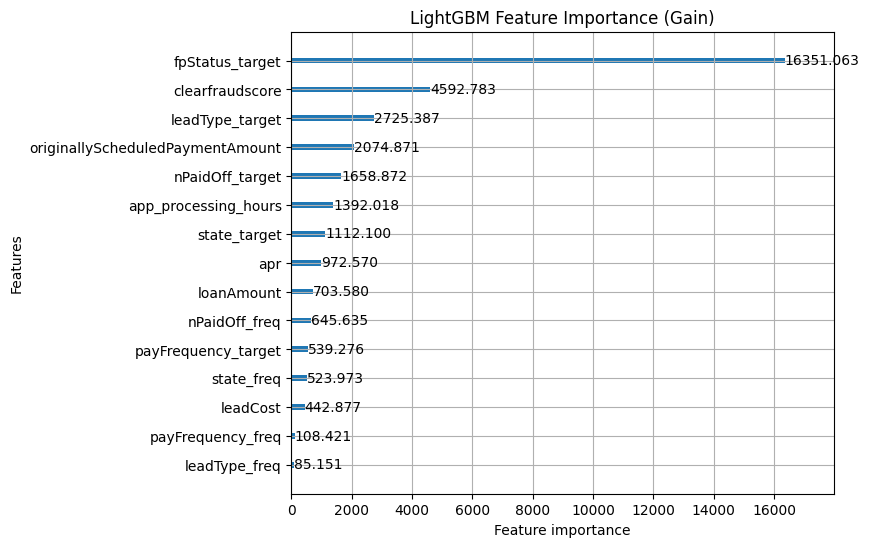

In [41]:
# Plot feature importance using Gain
lgb.plot_importance(final_model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

## Conclusion

In this notebook, we have successfully loaded, prepared, and analyzed the `loan.csv` dataset to predict loan defaults. Through various steps of data cleaning, feature engineering, and exploratory data analysis, we have prepared the dataset for robust model training. We utilized LightGBM for model training, which allowed us to efficiently handle the data without extensive preprocessing. Finally, we visualized the feature importance to understand the key factors influencing loan defaults.